In [1]:
import xarray as xr
import einops

In [2]:
import matplotlib.pyplot as plt
import numpy as np

In [3]:
from tqdm import tqdm

In [4]:
def _rolling_window(a, window):
    shape = a.shape[:-1] + (a.shape[-1] - window + 1, window)
    strides = a.strides + (a.strides[-1],)
    return np.lib.stride_tricks.as_strided(
        a, shape=shape, strides=strides, writeable=False
    )

In [5]:
ds_rad = xr.open_dataset('/pd/data/CML/data/reference/radklim_yw_1min/2018_2020_radklim_yw_1_min.nc', engine='netcdf4')
ds_cml = xr.open_dataset('/pd/data/CML/data/processed/proc2021.001/proc_hess_amt/proc_cnn_gapstandard_2020_05.nc', engine='netcdf4')


In [8]:
ds_rad

<xarray.Dataset> Size: 49GB
Dimensions:           (cml_id: 3904, time: 1578236)
Coordinates:
  * cml_id            (cml_id) <U17 265kB 'BY0081_2_BY1150_2' ... 'SY8534_2_S...
    length            (cml_id) float64 31kB ...
    site_a_longitude  (cml_id) float64 31kB ...
    site_b_latitude   (cml_id) float64 31kB ...
    site_b_longitude  (cml_id) float64 31kB ...
    site_a_latitude   (cml_id) float64 31kB ...
  * time              (time) datetime64[ns] 13MB 2018-01-01 ... 2020-12-31T23...
Data variables:
    rainfall_amount   (time, cml_id) float64 49GB ...

In [ ]:
ds_rad = ds_rad.reindex(time=ds_cml.time.values,method='nearest',tolerance='10s')
ds_cml['radar_rainfall'] = ds_rad.rainfall_amount
ds_cml = ds_cml.isel(cml_id=np.arange(10)).load()
ds_cml['r_median_tl'] = ds_cml.txrx.rolling(time=60*72, min_periods=60*3).median()
ds_cml['tl_norm'] = ds_cml['txrx']-ds_cml['r_median_tl']
ds_cml = ds_cml.sel(time=slice('2020-05-10','2020-05-15'))
tl = einops.rearrange(ds_cml.tl_norm.values, 'c i t -> t i c')
rr = ds_cml.radar_rainfall.values


In [8]:
l = []
r = []
for i in tqdm(range(tl.shape[1])):
    tll = []
    for j in range(tl.shape[2]):
        tll.append(_rolling_window(tl[:,i,j], 180))
    r.append(_rolling_window(rr[:,i], 180))
    l.append(tll)
l = einops.rearrange(np.array(l), 'i c b t -> (b i) t c')
r = einops.rearrange(np.array(r), 'i b t -> (b i) t')
ds = xr.Dataset()
ds['tl'] = ('sample_number','timestep','channel_id',), l
ds['radar'] = ('sample_number','timestep',), r
ds['tl_valid'] = ds.tl.isnull().sum(dim='timestep').sum(dim='channel_id')==0

100%|██████████| 10/10 [00:00<00:00, 37854.73it/s]


In [10]:
ds = ds.sel(sample_number=ds.sample_number[ds.tl_valid])

In [12]:
ds.nbytes/1e9

0.331200329

In [13]:
ds.to_netcdf('/bg/fast/aihydromet/cml_wet_dry_radklim/example_data.nc')

In [9]:
ds = xr.open_dataset('/bg/fast/aihydromet/cml_wet_dry_radklim/example_data.nc')

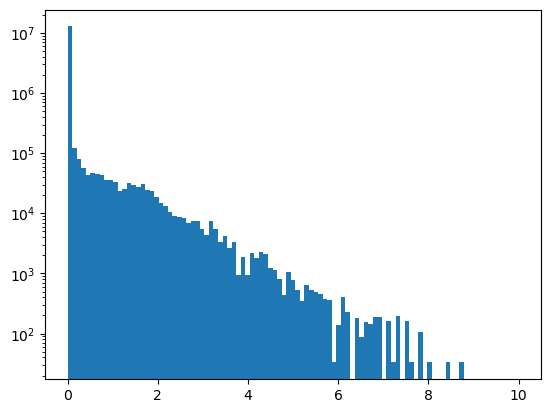

In [19]:
plt.hist(np.ravel(ds.radar.values)*60, bins=np.linspace(0,10,100))
plt.yscale('log')

In [28]:
ds

<xarray.Dataset> Size: 331MB
Dimensions:    (sample_number: 76649, timestep: 180, channel_id: 2)
Dimensions without coordinates: sample_number, timestep, channel_id
Data variables:
    tl         (sample_number, timestep, channel_id) float64 221MB ...
    radar      (sample_number, timestep) float64 110MB 0.0 0.0 0.0 ... 0.0 0.0
    tl_valid   (sample_number) bool 77kB ...
    wet_radar  (sample_number) bool 77kB False False False ... False False False

In [27]:
ds['wet_radar'] = ((ds.radar*60)>0.1).isel(timestep=-5)


In [22]:
np.sum(ds.wet_radar)/len(np.ravel(ds.wet_radar.values))

<xarray.DataArray 'wet_radar' ()> Size: 8B
array(0.06721498)

In [23]:
from sklearn.utils import shuffle

In [33]:
def balance_classes(a, boo):
    lsn=len(a.sample_number)
    ind = np.arange(lsn)
    ind_true = shuffle(ind[boo])
    ind_false = ind[~boo]
    ind_true = ind_true[:np.sum(~boo)]
    print(1-(2*len(ind_false)/lsn))
    return a.isel(sample_number=np.concatenate([ind_true,ind_false]))

In [34]:
a = balance_classes(ds, ~ds.wet_radar.values)

0.8728228678782501


In [35]:
a

<xarray.Dataset> Size: 42MB
Dimensions:    (sample_number: 9748, timestep: 180, channel_id: 2)
Dimensions without coordinates: sample_number, timestep, channel_id
Data variables:
    tl         (sample_number, timestep, channel_id) float64 28MB -2.0 ... -1.3
    radar      (sample_number, timestep) float64 14MB 0.0 0.0 ... 0.0009235
    tl_valid   (sample_number) bool 10kB ...
    wet_radar  (sample_number) bool 10kB False False False ... True True True